In [1]:
import os
import sys
import numpy as np

ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

import pandas as pd
from utils import *

In [18]:
import itertools

def find_ngrams(text: str, n: int):
    return [text[i:i + n] for i in range(len(text) - n + 1)]

def jaccard_similarity(a: set[str], b: set[str]) -> float:
    intersection = a.intersection(b)
    union = a.union(b)

    return len(intersection) / len(union) if len(union) != 0 else 0

class MinHashDeduplicator:
    '''
    A class to deduplicate articles using MinHash
    '''
    def __init__(self, k=6, threshold=0.51):
        self.k = k
        self.treshold = threshold

    def calculate_minhash(self, s1: set[int], s2: set[int]):
        X = set(sorted(s1 | s2)[:self.k])
        Y = X & s1 & s2
        return len(Y) / self.k

    def calculate_jaccard(self, r1, r2):
        scores = [jaccard_similarity(a, b) for a, b in zip(r1, r2) if not pd.isna(a) and not pd.isna(b)]
        return np.mean(scores)

    def predict(self, articles: pd.DataFrame) -> list[int]:
        # change each row to set without hashed values, without NaNs
        rows = []
        rows_ngram = []
        for _, row in articles.iterrows():
            for_ngrams = row[["titles", "contributors", "periodical", "abstract"]].tolist()
            row_ngram = []
            for element in for_ngrams:
                if element is None or element != element:
                    row_ngram.append(None)
                else:
                    if isinstance(element, float):
                        print(element)
                    row_ngram.append(set(find_ngrams(element, 2)))

            rows_ngram.append(row_ngram)

            row = row.dropna().apply(hash).to_list()
            row.sort()
            rows.append(set(row[:self.k]))

        result = [0 for _ in rows]
        # for each pair of rows calculate estimate
        for (i, j) in itertools.combinations(range(len(result)), 2):
            if self.calculate_minhash(rows[i], rows[j]) > self.treshold:
                if self.calculate_jaccard(rows_ngram[i], rows_ngram[j]) > 0.65:
                    result[i] = 1
                    result[j] = 1
        return result


In [3]:
df = prepare_dataset()

Loading datasets:   0%|          | 0/5 [00:00<?, ?it/s]

Loading datasets: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


In [16]:
times = []
f1s = []

In [19]:
deduplicator = MinHashDeduplicator(threshold=0.8)
benchmark = Benchmark(deduplicator)
result = benchmark.evaluate(df.drop(columns=["caption", "label", "database", "source-app"]), df['label'])
times.append(result["prediction_time_sec"])
f1s.append(result["f1"])

In [20]:
deduplicator = MinHashDeduplicator(threshold=0.64)
benchmark = Benchmark(deduplicator)
result = benchmark.evaluate(df.drop(columns=["caption", "label", "database", "source-app"]), df['label'])
times.append(result["prediction_time_sec"])
f1s.append(result["f1"])

In [21]:
deduplicator = MinHashDeduplicator(threshold=0.48)
benchmark = Benchmark(deduplicator)
result = benchmark.evaluate(df.drop(columns=["caption", "label", "database", "source-app"]), df['label'])
times.append(result["prediction_time_sec"])
f1s.append(result["f1"])

In [22]:
deduplicator = MinHashDeduplicator(threshold=0.32)
benchmark = Benchmark(deduplicator)
result = benchmark.evaluate(df.drop(columns=["caption", "label", "database", "source-app"]), df['label'])
times.append(result["prediction_time_sec"])
f1s.append(result["f1"])

In [23]:
deduplicator = MinHashDeduplicator(threshold=0.16)
benchmark = Benchmark(deduplicator)
result = benchmark.evaluate(df.drop(columns=["caption", "label", "database", "source-app"]), df['label'])
times.append(result["prediction_time_sec"])
f1s.append(result["f1"])

In [24]:
print(times)
print(f1s)

[62.06077027320862, 62.28947114944458, 63.86949133872986, 73.96885752677917, 526.327832698822]
[0.012894906511926924, 0.053418656257432494, 0.2275004091648092, 0.5779510248985051, 0.861492382057169]


In [1]:
import matplotlib.pyplot as plt

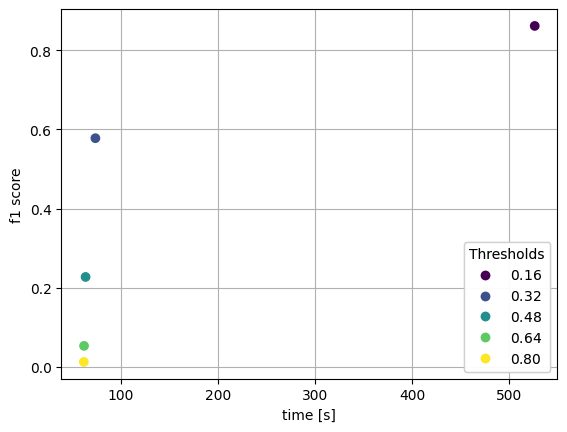

In [9]:
f1s.reverse()
times.reverse()
thresholds = [0.16, 0.32, 0.48, 0.64, 0.80]


fig, ax = plt.subplots()
scatter = ax.scatter(times, f1s, c=thresholds)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Thresholds")
ax.add_artist(legend1)
ax.grid()
ax.set_xlabel("time [s]")
ax.set_ylabel("f1 score")
plt.show()